In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#Reads a file and returns two numpy arrays for the values on the two specified columns
def read_csv(file, colName1, colName2):
    reader = pd.read_csv(file, encoding='latin-1')
    col1 = reader[colName1]
    col2 = reader[colName2]
    return col1, col2

In [3]:
#Returns the ratio between two numbers
def get_ratio(num1,num2):
    if(num1 > num2):
        return num1/num2
    else:
        return num2/num1

In [4]:
#This function is in charge of plotting the bar chart with the percentages for both Ham and Spam emails
def plot_ratio(counter, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    frequencies = list(counter.values())
    names = list(counter.keys())
    
    totalSamples = frequencies[0]+frequencies[1]
    ham = (frequencies[0]/totalSamples)*100  
    spam = (frequencies[1]/totalSamples)*100

    x_coordinates = np.arange(len(counter))	
    ax.bar(x_coordinates, frequencies, align='center')
    ax.set_title('Percentages: HAM - ' + str(round(ham,2)) +'%  |  SPAM - ' + str(round(spam,2)) +'%')
    ax.xaxis.set_major_locator(plt.FixedLocator(x_coordinates))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(names))

    return ax


In [5]:
#This function is in charge of plotting the counts for each item on the counter variable as a bar chart
def plot_words_from_counter(title, counter, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    frequencies = []
    names = []
    for i in range (len(counter)):
        frequencies.append(counter[i][1])
        names.append(counter[i][0])
        
    x_coordinates = np.arange(len(counter))	
    ax.bar(x_coordinates, frequencies, align='center')
    ax.set_title(title)
    plt.xticks(rotation=45)
    ax.xaxis.set_major_locator(plt.FixedLocator(x_coordinates))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(names))
    
    return ax

In [6]:
#This function returns two 'dictionaries', one for spam words and another one for non-spam words in the form of:
# <word> : <total number of ocurrencies>
def count_words(cnt_spam, cnt_no_spam, sms, labels):
    additional_stop_word_list = ['2', 'ur', 'u', '1', 't', 's', 'm', 'it', '4', 'å', 'lt', 'ok', 'll', 'gt', 'lor']
    stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_word_list)
    
    for i in range (len(sms)):
        sms[i] = re.sub('\W', ' ', sms[i].lower())
        message = sms[i].split()
        for word in message:
            if (word not in stop_words):
                if(labels[i] == 'spam'):
                    cnt_spam[word] += 1
                else:
                    cnt_no_spam[word] +=1

In [7]:
#Recodes the dependent variable (y) to 1/0 instead of spam/ham
def map_labels(labels):
    y = []
    for i in range(len(labels)):
        if(labels[i] == 'spam'):
            y.append(1)
        else:
            y.append(0)
    return y

In [8]:
#This function tests different parameters on the model and returns the
#accuracy for each test in order to determine the best parameters to use for getting the best accuracy
def gridSearch(X_train, Y_train, X_test, Y_test):
		
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                      'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
    
    scores = ['precision', 'recall']
    
    for score in scores:
        print('# Tuning hyper-parameters for %s' % score)

        clf = GridSearchCV(SVC(), tuned_parameters, scoring='%s_macro' % score)	
        clf.fit(X_train, Y_train)

        print('\nThe best parameter set is:\n')
        print(clf.best_params_)
        print('\nGrid scores on development set:\n')

        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print('%0.3f (+/-%0.03f) for %r'
              % (mean, std * 2, params))

        print()
        print('Detailed classification report:\n')
        print('The model is trained on the full development set.')
        print('The scores are computed on the full evaluation set.\n')

        y_true, y_pred = Y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print ('Accuracy:     '+ str(accuracy_score(Y_test, y_pred))+'\n')


In [9]:
def train(X_train, Y_train, X_test, Y_test, model):
    
    clf = None
    
    if (model == 'Random Forest'):
        clf = RandomForestClassifier(n_estimators=250, random_state=0, max_features=2)
    elif (model == 'Logistic Regression'):
        clf = LogisticRegression(solver='liblinear', random_state=0)
    elif (model == 'SVC'):
        clf = SVC(C=100, kernel='rbf', gamma=0.001)
    	
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    target_names = ['0','1']
    
    header_line = '====================== ' + model + ' ======================'
    print( header_line )
    print('Classification Report:')
    print(classification_report(Y_test, y_pred, target_names=target_names))
    print ('Accuracy:     '+ str(accuracy_score(Y_test, y_pred)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_test, y_pred, labels=[0,1]))
    print( '=' * len(header_line) )
    print()


In [10]:
#Main function. Starts the processing

labels, sms = read_csv('C:\\Users\\priscilla.mora\\Documents\\EmailData\\spam.csv','v1','v2')

#Converts the numpy array to list
sms = sms.tolist()

#Creates two empty counters one for spam and another one for non-spam
cnt_spam = Counter()
cnt_no_spam = Counter()

#Counts the number of ocurrencies for every word for both spam and non-spam messages
count_words(cnt_spam, cnt_no_spam, sms, labels)

additional_stop_word_list = ['2', 'ur', 'u', '1', 't', 's', 'm', 'it', '4', 'å', 'lt', 'ok', 'll', 'gt', 'lor']
stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_word_list)
vectorizer = CountVectorizer( stop_words=stop_words )
x = vectorizer.fit_transform(sms)
y = map_labels(labels)

In [11]:
print('X dimension shape after being vectorized:')
print(x.shape)

X dimension shape after being vectorized:
(5572, 8398)


In [12]:
print('Unique words:')
print(vectorizer.vocabulary_) #The numbers are not counts, they are the position in the sparse vector

Unique words:
{'jurong': 4223, 'point': 5736, 'crazy': 2271, 'available': 1271, 'bugis': 1703, 'great': 3534, 'world': 8221, 'la': 4348, 'buffet': 1701, 'cine': 1994, 'got': 3494, 'amore': 1051, 'wat': 8020, 'lar': 4384, 'joking': 4191, 'wif': 8128, 'oni': 5364, 'free': 3265, 'entry': 2875, 'wkly': 8179, 'comp': 2110, 'win': 8140, 'fa': 3005, 'cup': 2329, 'final': 3121, 'tkts': 7514, '21st': 411, '2005': 402, 'text': 7383, '87121': 784, 'receive': 6110, 'question': 6005, 'std': 7023, 'txt': 7696, 'rate': 6057, 'apply': 1128, '08452810075over18': 77, 'dun': 2738, 'say': 6445, 'early': 2757, 'hor': 3814, 'nah': 5088, 'don': 2651, 'think': 7438, 'goes': 3458, 'usf': 7831, 'lives': 4534, 'freemsg': 3272, 'hey': 3731, 'darling': 2386, 'week': 8065, 'word': 8212, 'like': 4484, 'fun': 3323, 'tb': 7318, 'xxx': 8286, 'chgs': 1948, 'send': 6531, '50': 607, 'rcv': 6069, 'brother': 1674, 'speak': 6905, 'treat': 7629, 'aids': 985, 'patent': 5541, 'request': 6219, 'melle': 4829, 'oru': 5421, 'minnam

In [13]:
print('Stop words')
print(vectorizer.stop_words)

Stop words
frozenset({'when', 'via', 'latterly', 'three', 'whence', 'll', 'whom', 'nevertheless', 'against', 'together', 'ur', 'than', 'fire', 'sometime', 'anywhere', 'de', 'among', 'most', 'very', 'someone', 'seems', 'å', 'towards', 'perhaps', 'namely', 'himself', 'take', 'through', 'under', 'give', 'in', 'something', 'yet', 'which', 'elsewhere', 'are', 'somehow', 'neither', 'that', 'seemed', 'fifty', 'mill', 'whether', 'his', 'enough', 'anyone', 'these', 'she', 'throughout', 'wherever', 'had', 'few', 'myself', 'interest', 'what', 'although', 'next', 'hereby', 'other', 'see', 'hereafter', 'often', 'alone', 'last', 'gt', 'still', 'down', 'am', 'therein', 'us', 'meanwhile', 'them', 'several', 'both', 'hereupon', 'whereby', 'been', 'after', 'thereby', 'being', 'too', 'some', 'by', 'because', 'mostly', 'indeed', 'go', 'cry', 'above', 'always', 'cant', 'on', 'our', 'themselves', 'onto', 'sometimes', 'thereupon', 'this', 'co', 'such', 'afterwards', 'formerly', 'bill', 'almost', 'into', 'bey

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.30, random_state=42)

#Required only the first time
gridSearch(X_train, Y_train, X_test, Y_test)

# Tuning hyper-parameters for precision

The best parameter set is:

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.833 (+/-0.401) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.432 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.977 (+/-0.011) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.833 (+/-0.401) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.977 (+/-0.013) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.979 (+/-0.006) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.978 (+/-0.016) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.980 (+/-0.009) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.979 (+/-0.013) for {'C': 1, 'kernel': 'linear'}
0.979 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.979 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.979 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evalu

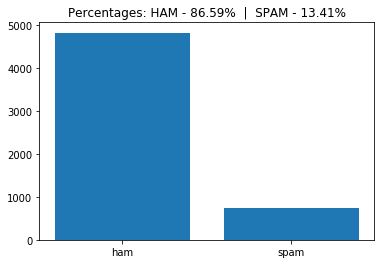

In [15]:
#-------------------------- Ratio between spam / no-spam ----------------------------------
spam_count = Counter(labels)
plot_ratio(spam_count)
plt.show()

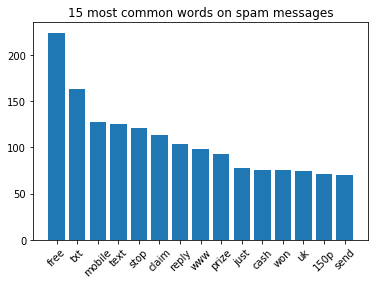

In [16]:
#-------------------------- Counting words --------------------------------------------------
plot_words_from_counter('15 most common words on spam messages', cnt_spam.most_common(15))
plt.show()

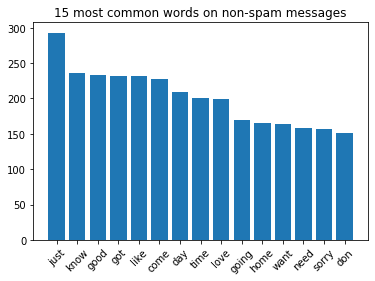

In [17]:
plot_words_from_counter('15 most common words on non-spam messages', cnt_no_spam.most_common(15))
plt.show()

In [18]:
#---------------------- Training the model -----------------------------------------------
#SVC
train(X_train, Y_train, X_test, Y_test, 'SVC')

====================== SVC ======================
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       1.00      0.88      0.94       219

    accuracy                           0.98      1672
   macro avg       0.99      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Accuracy:     0.9844497607655502
Confusion Matrix:
[[1453    0]
 [  26  193]]



In [19]:
#Random Forest
train(X_train, Y_train, X_test, Y_test, 'Random Forest')

====================== Random Forest ======================
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1453
           1       1.00      0.71      0.83       219

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672

Accuracy:     0.9617224880382775
Confusion Matrix:
[[1453    0]
 [  64  155]]



In [20]:
#Logistic Regression
train(X_train, Y_train, X_test, Y_test, 'Logistic Regression')

====================== Logistic Regression ======================
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1453
           1       1.00      0.84      0.91       219

    accuracy                           0.98      1672
   macro avg       0.99      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672

Accuracy:     0.979066985645933
Confusion Matrix:
[[1453    0]
 [  35  184]]

